In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc,confusion_matrix
from sklearn.metrics import plot_roc_curve
import multiprocessing
import gc
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [2]:
# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


#Summary Function

def data_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [3]:
# train_transaction = pd.read_csv("../Data/train_transaction.csv")
# train_identity = pd.read_csv("../Data/train_identity.csv")
# test_transaction = pd.read_csv("../Data/test_transaction.csv")
# test_identity = pd.read_csv("../Data/test_identity.csv")
# sample_submission = pd.read_csv("../Data/sample_submission.csv")

In [4]:
# test_identity.rename(columns = {'id-01':'id_01','id-02':'id_02','id-03': 'id_03','id-04': 'id_04','id-05': 'id_05','id-06': 'id_06',
#               'id-07': 'id_07','id-08': 'id_08','id-09': 'id_09','id-10': 'id_10','id-11': 'id_11','id-12': 'id_12', 
#               'id-13': 'id_13','id-14': 'id_14','id-15': 'id_15','id-16': 'id_16','id-17': 'id_17','id-18': 'id_18',
#               'id-19': 'id_19','id-20': 'id_20','id-21': 'id_21','id-22': 'id_22','id-23': 'id_23','id-24': 'id_24',
#               'id-25': 'id_25','id-26': 'id_26','id-27': 'id_27','id-28': 'id_28','id-29': 'id_29','id-30': 'id_30',
#               'id-31': 'id_31','id-32': 'id_32','id-33': 'id_33','id-34': 'id_34','id-35': 'id_35','id-36': 'id_36',
#               'id-37': 'id_37','id-38': 'id_38'}, inplace = 1)

In [5]:
# train_transaction = reduce_mem_usage(train_transaction)
# train_identity = reduce_mem_usage(train_identity)
# test_transaction = reduce_mem_usage(test_transaction)
# test_identity = reduce_mem_usage(test_identity)
# sample_submission  = reduce_mem_usage(sample_submission)

In [6]:
# df_train = train_transaction.merge(train_identity,on=['TransactionID'],how='left')
# df_train.to_csv('../Data/train_combined.csv',index=False)
# gc.collect()
# df_train.head()


In [7]:
# df_test = test_transaction.merge(test_identity,on=['TransactionID'],how='left')
# df_test.to_csv('../Data/test_combined.csv',index=False)
# gc.collect()
# df_test.head()

In [8]:
df_train = pd.read_csv('../Data/train_combined.csv')
df_test = pd.read_csv('../Data/test_combined.csv')
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


In [9]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [10]:
# column details
cat_cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])



type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

######################################################################################

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols =  [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 
    'id_09', 'id_10', 'id_11'
]


In [11]:
## Train and test split¶
y_train_ = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()

            

(590540, 433)
(506691, 433)


4

In [12]:
# Label encoding all cat features
for col in X_train.columns:
    if col in cat_cols:
        # label encode all cat columns
        dff = pd.concat([X_train[col],X_test[col]])
        dff,_ = pd.factorize(dff,sort=True)
        if dff.max()>32000: 
            print(col,'needs int32 datatype')
            
        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')

In [13]:
# Scaling numeric features
cols = X_train.columns
for col in cols:
    if col not in cat_cols and col not in id_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

In [14]:
idx_train = X_train.index[:int(X_train.shape[0]*0.75)]  
idx_validation = X_train.index[int(X_train.shape[0]*0.75):]

x_train,y_train = X_train.iloc[idx_train],y_train_.iloc[idx_train]
x_cv_,y_cv = X_train.iloc[idx_validation],y_train_.iloc[idx_validation]


print(x_train.shape)
print(x_cv_.shape)
print(y_train.shape)
print(y_cv.shape)

(442905, 433)
(147635, 433)
(442905,)
(147635,)


In [15]:

# Put models in a dictionary
models = {
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(),
          "Xgboost": xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    model_classification = {}
    model_roc = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
        
        # Make preidctions on test data
        y_preds = model.predict(X_test)
        # Show classification report
        model_classification[name] = print(classification_report(y_test, y_preds))
        # plot roc curve
        model_roc[name] = plot_roc_curve(model, X_test, y_test);
        
    return model_scores, model_classification, model_roc

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    142535
           1       0.00      0.00      0.00      5100

    accuracy                           0.97    147635
   macro avg       0.48      0.50      0.49    147635
weighted avg       0.93      0.97      0.95    147635

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.80      0.30      0.44      5100

    accuracy                           0.97    147635
   macro avg       0.89      0.65      0.71    147635
weighted avg       0.97      0.97      0.97    147635

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.78      0.35      0.49      5100

    accuracy                           0.97    147635
   macro avg       0.88      0.68      0.74    147635
weighted avg       0.97      0.97      0.97    147635



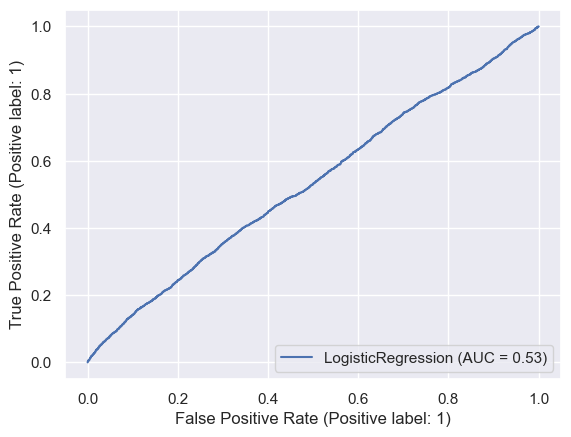

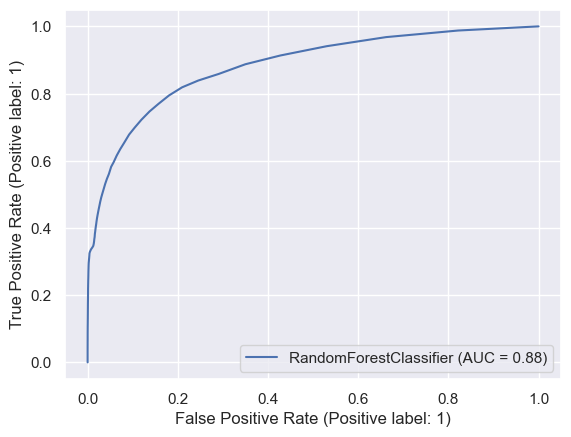

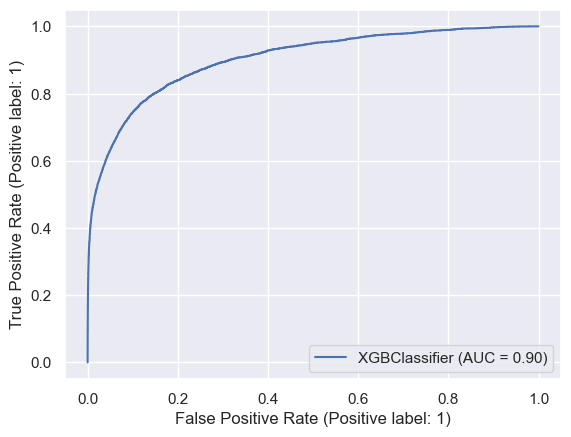

In [16]:
model_scores = fit_and_score(models=models,
                             X_train=x_train,
                             X_test=x_cv_,
                             y_train=y_train,
                             y_test=y_cv)

In [17]:
model_scores[0]

{'Logistic Regression': 0.9654553459545501,
 'Random Forest': 0.9732109594608325,
 'Xgboost': 0.9741931113895756}

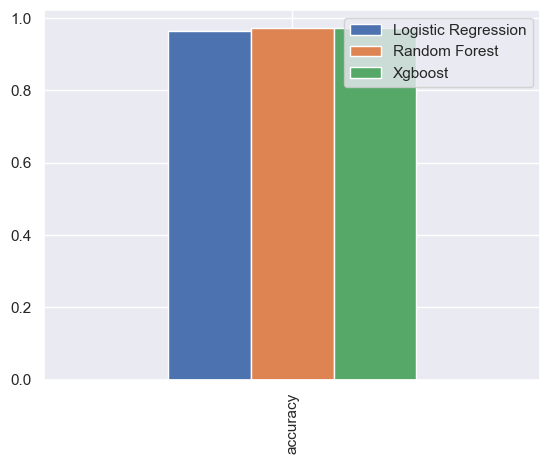

In [18]:
model_compare = pd.DataFrame(model_scores[0], index=['accuracy'])
model_compare.plot.bar();

## Logistic regression

In [19]:
from sklearn.decomposition import PCA

pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0, max_iter=10000, tol=0.1)
)

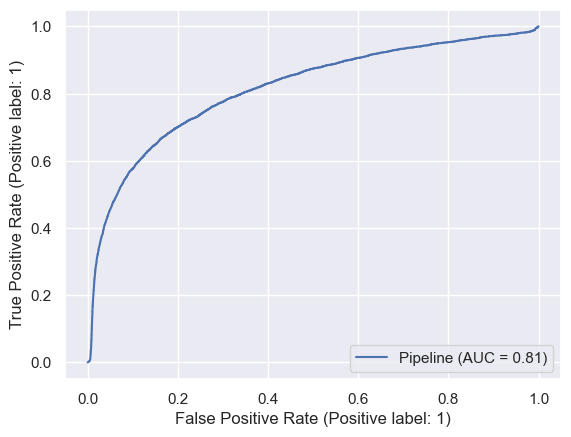

In [20]:
model = pipe.fit(x_train, y_train)
plot_roc_curve(model, x_cv_, y_cv)

In [21]:
# Make preidctions on test data
y_preds = model.predict(x_cv_)
# Show classification report
print(classification_report(y_cv, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    142535
           1       0.37      0.24      0.29      5100

    accuracy                           0.96    147635
   macro avg       0.67      0.61      0.63    147635
weighted avg       0.95      0.96      0.96    147635



In [22]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(x_train,y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 427342), (1, 427342)]


In [23]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0)
)

model = pipe.fit(X_resampled, y_resampled)

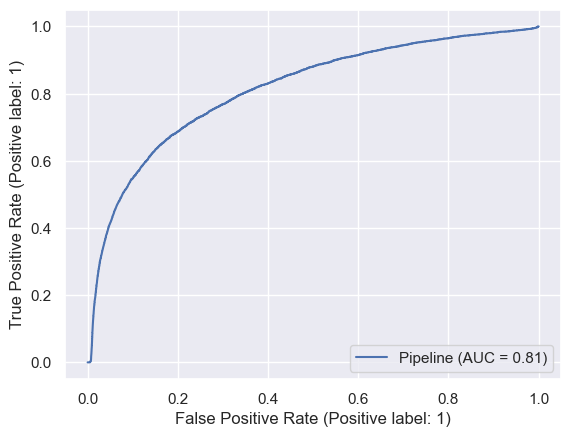

In [24]:
plot_roc_curve(model, x_cv_, y_cv)

In [25]:
# Make preidctions on test data
y_preds = model.predict(x_cv_)
# Show classification report
print(classification_report(y_cv, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80    142535
           1       0.08      0.79      0.14      5100

    accuracy                           0.67    147635
   macro avg       0.53      0.73      0.47    147635
weighted avg       0.96      0.67      0.77    147635



In [26]:
model = pipe.fit(x_train, y_train)
# "penalty": ["l1", "l2", "elasticnet", "none"],

In [27]:
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
# Different LogisticRegression hyperparameters
# in the solver instance the sag and saga are faster for large dataset and the liblinear is better for smaller dataset
# log_reg_grid = {"C": np.logspace(-5, 10, 30),
#                 "penalty": ["l1", "l2", "elasticnet", "none"],
#                 "solver": ["sag", "saga"]}

param_grid = {
    "pca__n_components": [i for i in range(10, 300, 20)],
    "logistic__C": np.logspace(-4, 4, 20),
}
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()


logistic = LogisticRegression(max_iter=10000, tol=0.1)

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])
# Setup grid hyperparameter search for LogisticRegression
search = GridSearchCV(pipe,
                          param_grid,
                          n_jobs=2,
                          verbose=True)

start = time()
# Fit grid hyperparameter search model
search.fit(x_train,y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(search.cv_results_["params"]))
)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


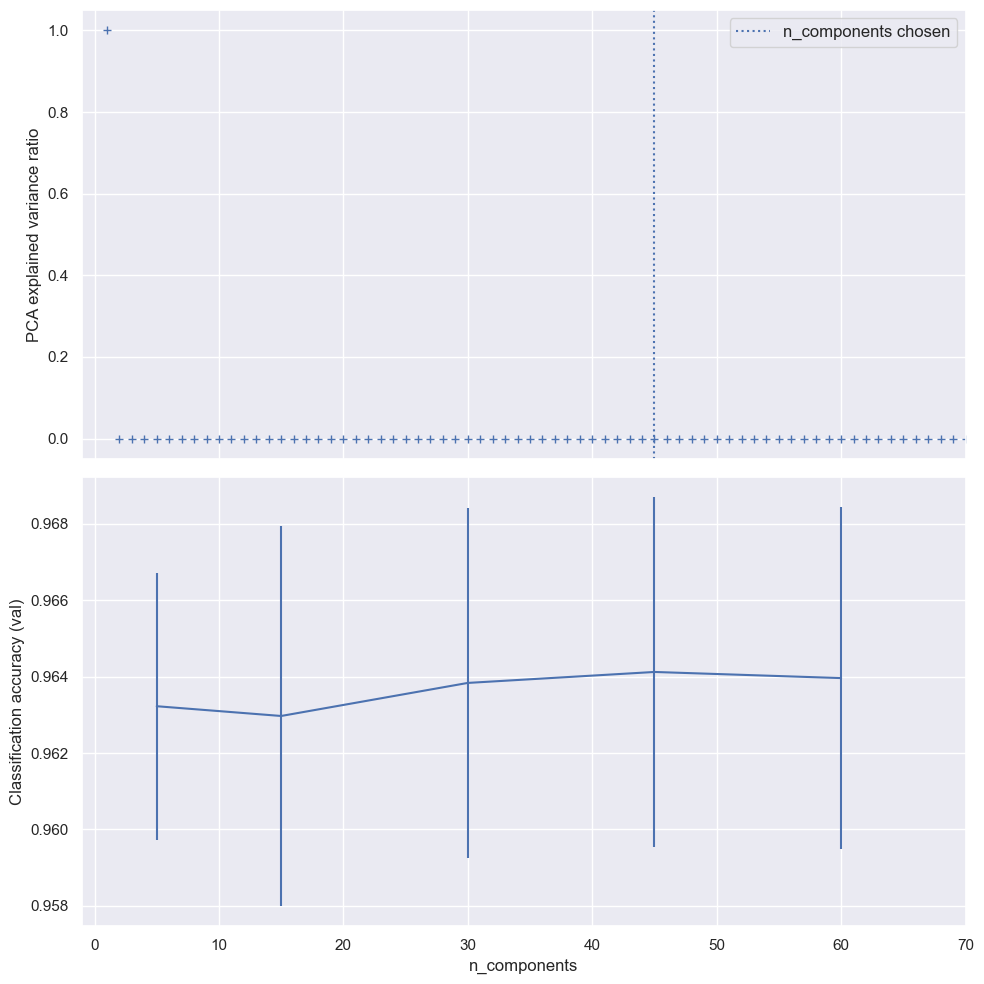

In [57]:
# Plot the PCA spectrum
pca.fit(x_train)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10,10))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")
ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))
# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)
best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")
plt.xlim(-1, 70)
plt.tight_layout()
plt.show()

In [ ]:
# Check the best parameters
gs_log_reg.best_params_

{'C': 0.0001, 'solver': 'liblinear'}

In [ ]:
# Evaluate the model
gs_log_reg.score(x_cv_, y_cv)

0.9654553459545501

In [ ]:
# Make preidctions on test data
y_preds = gs_log_reg.predict(x_cv_)

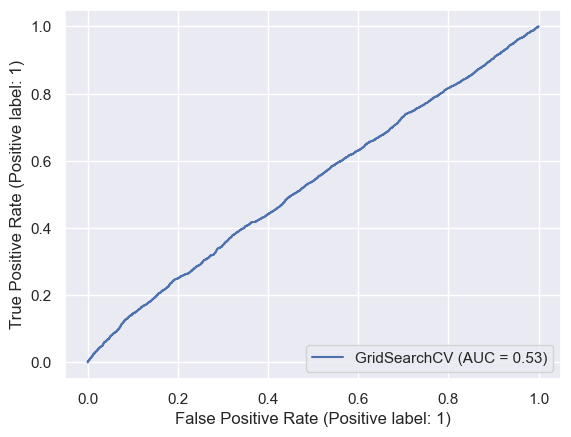

In [ ]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(gs_log_reg, x_cv_, y_cv);

In [ ]:
# Show classification report
print(classification_report(y_cv, y_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    142535
           1       0.00      0.00      0.00      5100

    accuracy                           0.97    147635
   macro avg       0.48      0.50      0.49    147635
weighted avg       0.93      0.97      0.95    147635



## Random forest

In [ ]:
model = RandomForestClassifier()
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, model.predict_proba(x_cv_)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 1.0
Area under test roc 0.8786651280008969


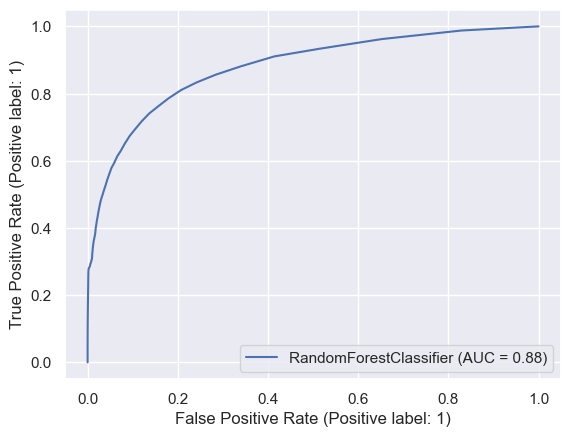

In [ ]:
# Make preidctions on test data
y_preds = model.predict(x_cv_)
# Plot ROC curve and calculate AUC metric
plot_roc_curve(model, x_cv_, y_cv);

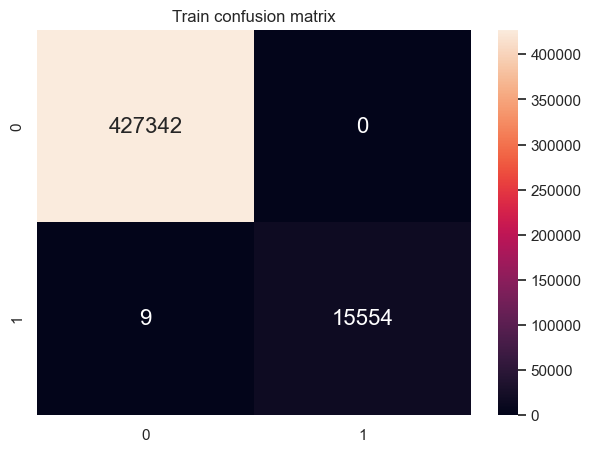

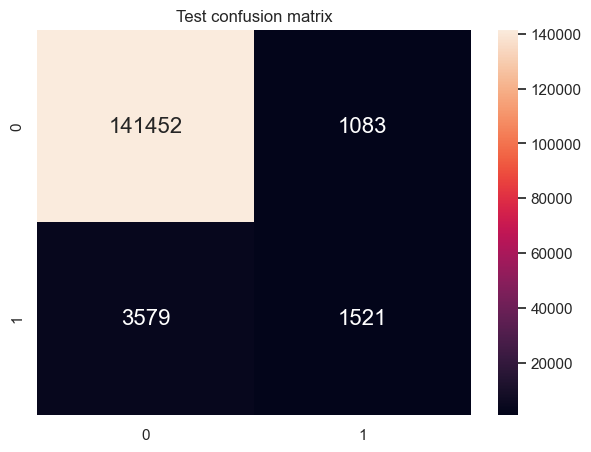

In [ ]:
train_cf = confusion_matrix(y_train,y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_cv,y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

## Xgboost

In [ ]:

params = {'n_estimators':[1000,2000],'max_depth':[3,6,12],'subsample':[0.4,0.8]}



clf = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4)



model = RandomizedSearchCV(estimator=clf, param_distributions=params, scoring='roc_auc', verbose=1, cv=3, n_iter=6)
model.fit(x_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.4,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=-1,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=6,
                   param_distributions={'max_depth': [3, 6, 12],
                                        'n_estimators': [1000, 2000],
                                        'subsample': [0.4, 0.8]},
                   scoring='roc_auc', verbose=1)

In [ ]:
model.best_params_

{'subsample': 0.8, 'n_estimators': 2000, 'max_depth': 6}

In [ ]:
model = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4,max_depth=12,n_estimators=2000,subsample=0.8)
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, model.predict_proba(x_cv_)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.9998884870954461
Area under test roc 0.913743711382894


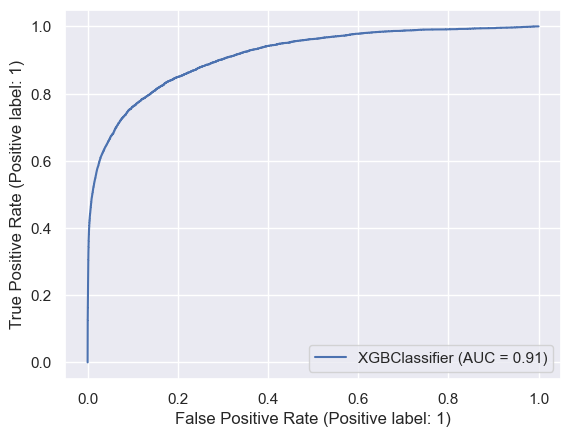

In [ ]:
# Make preidctions on test data
y_preds = model.predict(x_cv_)
# Plot ROC curve and calculate AUC metric
plot_roc_curve(model, x_cv_, y_cv);

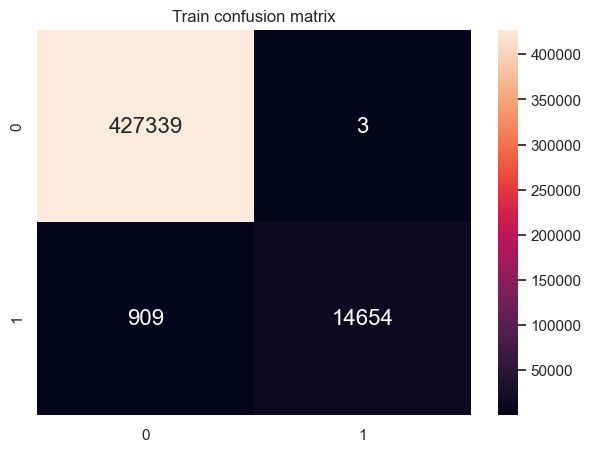

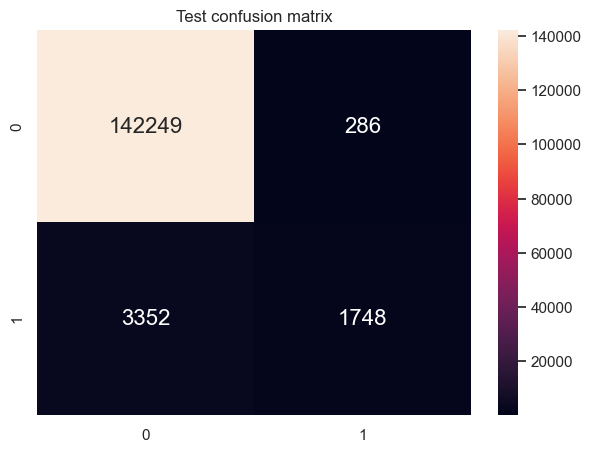

In [ ]:

train_cf = confusion_matrix(y_train,y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_cv,y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

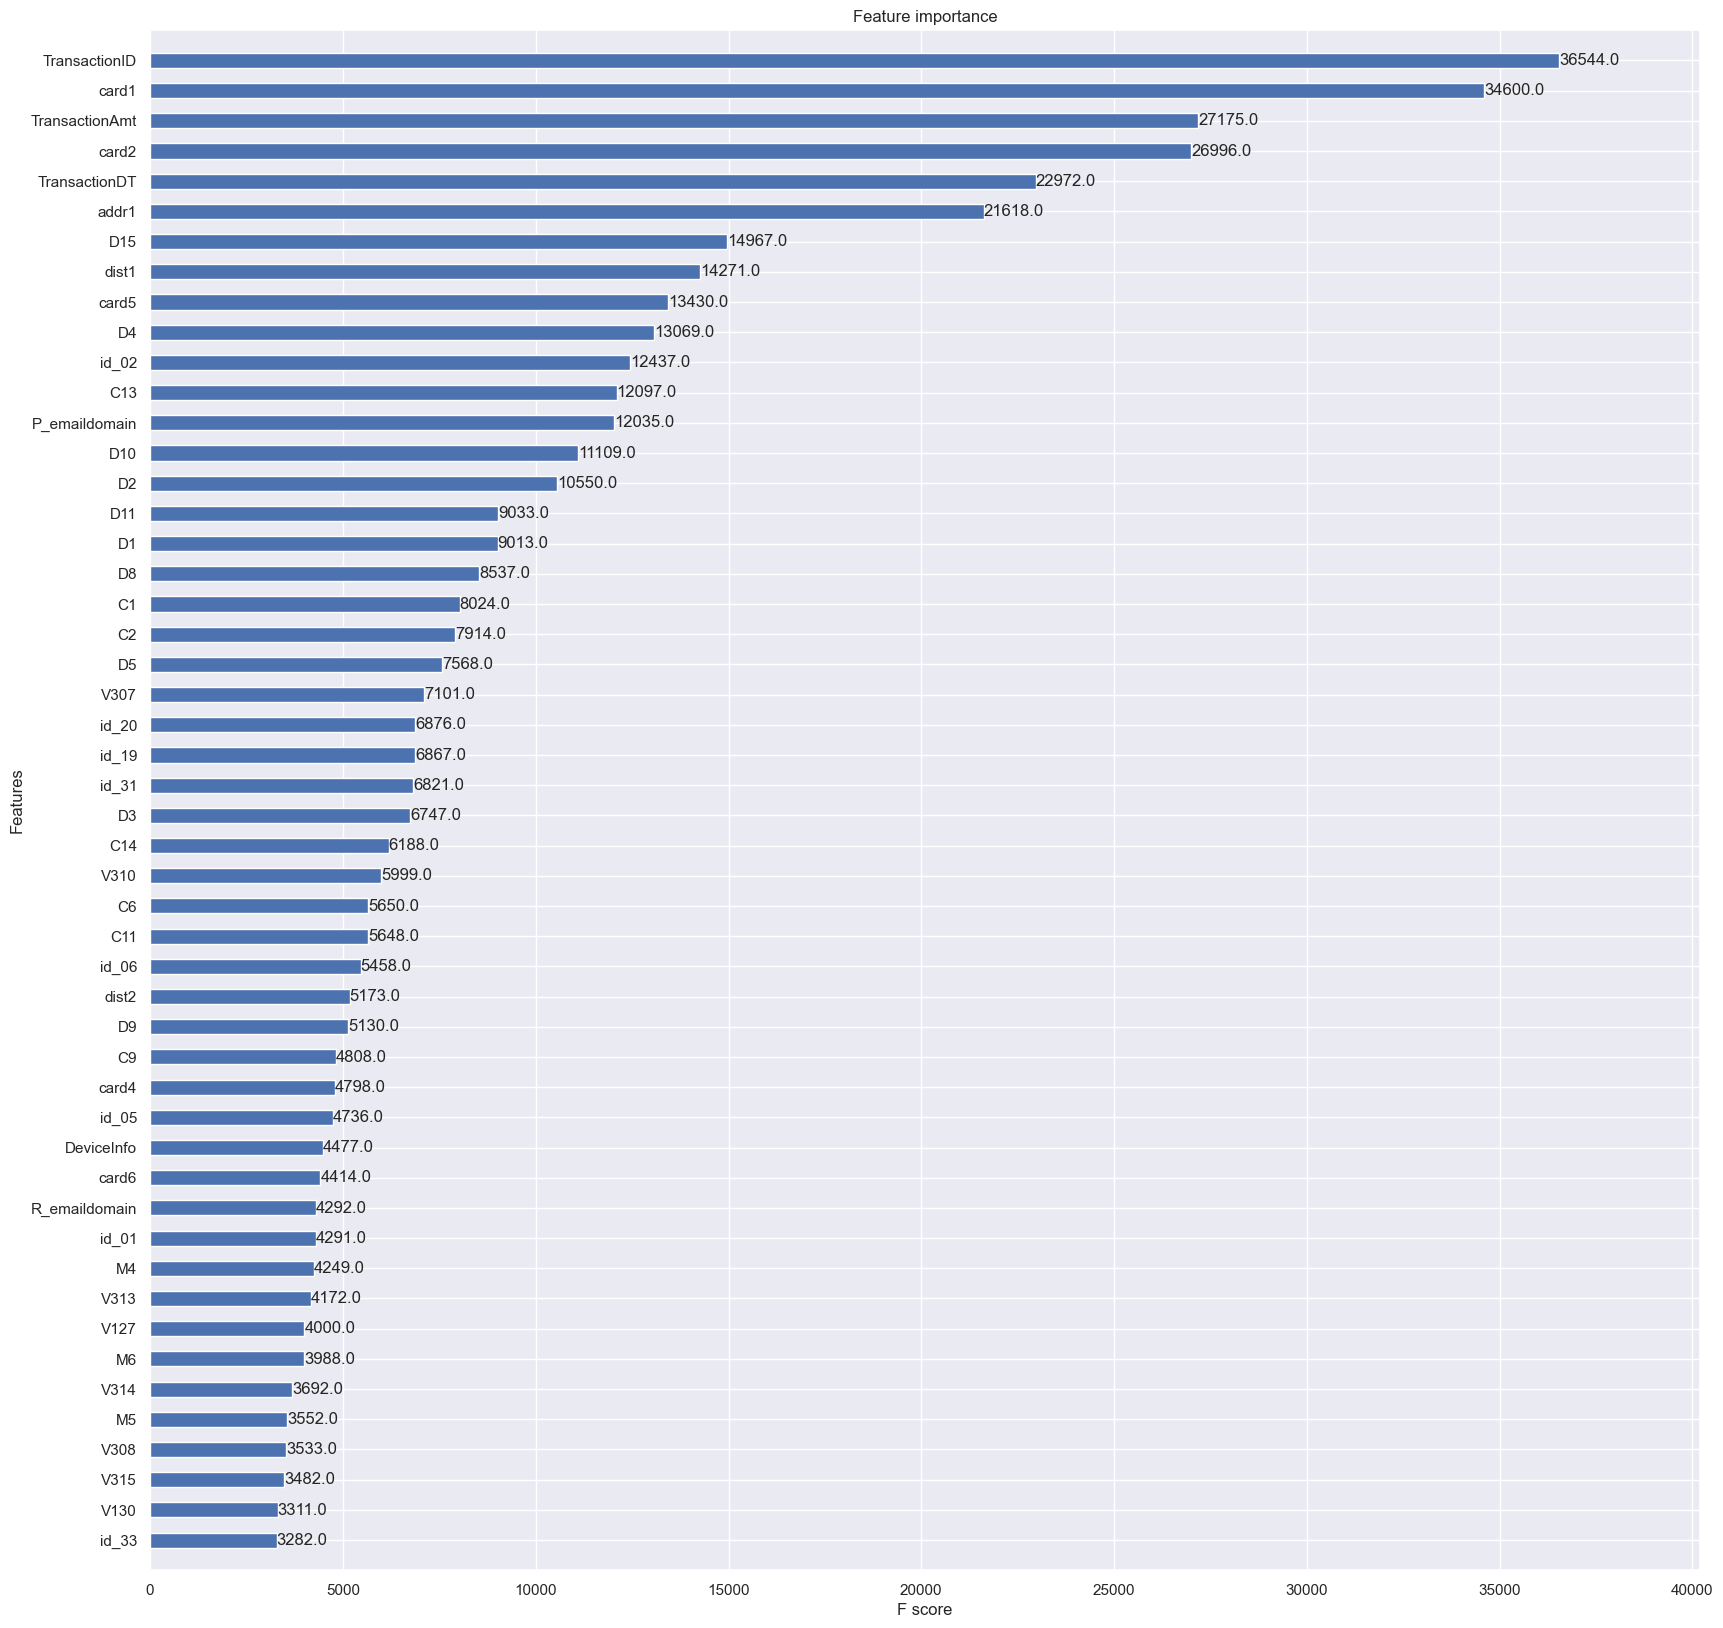

In [ ]:
from xgboost import plot_importance
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,20))
plot_importance(model,max_num_features=50,height=0.5,ax=axes)
plt.show()

## Let us do a early stoping to avoid overfit and check the perfomance

In [ ]:
clf = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4,max_depth=12,n_estimators=2000,
        subsample=0.8)


model = clf.fit(x_train, y_train, 
    eval_set=[(x_cv_,y_cv)],
    verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.80710
[50]	validation_0-auc:0.86682
[100]	validation_0-auc:0.87744
[150]	validation_0-auc:0.88886
[200]	validation_0-auc:0.89851
[250]	validation_0-auc:0.90696
[300]	validation_0-auc:0.91299
[350]	validation_0-auc:0.91721
[400]	validation_0-auc:0.91868
[450]	validation_0-auc:0.92001
[500]	validation_0-auc:0.92098
[550]	validation_0-auc:0.92150
[600]	validation_0-auc:0.92158
[650]	validation_0-auc:0.92164
[700]	validation_0-auc:0.92131
[743]	validation_0-auc:0.92121


In [ ]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, model.predict_proba(x_cv_)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.9953926856547165
Area under test roc 0.921725741940232


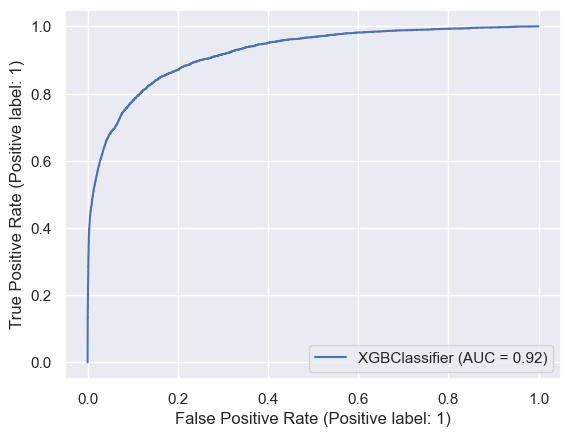

In [ ]:
# Make preidctions on test data
y_preds = model.predict(x_cv_)
# Plot ROC curve and calculate AUC metric
plot_roc_curve(model, x_cv_, y_cv);

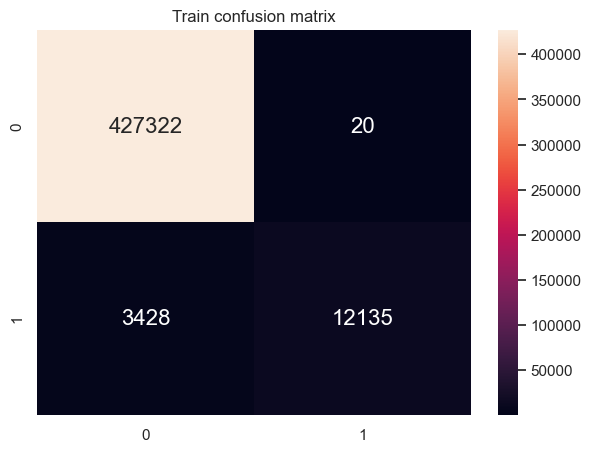

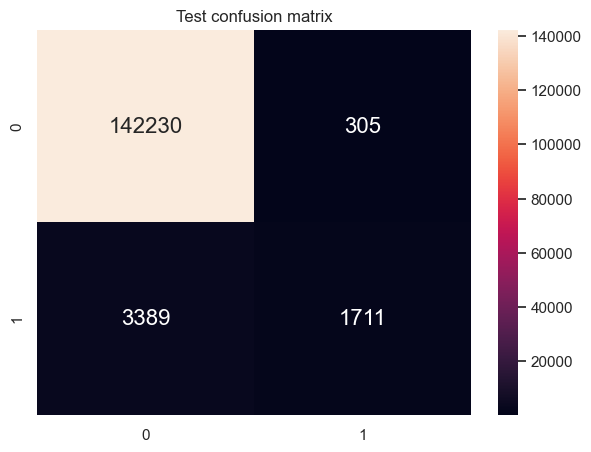

In [ ]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_cf = confusion_matrix(y_train,y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_cv,y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

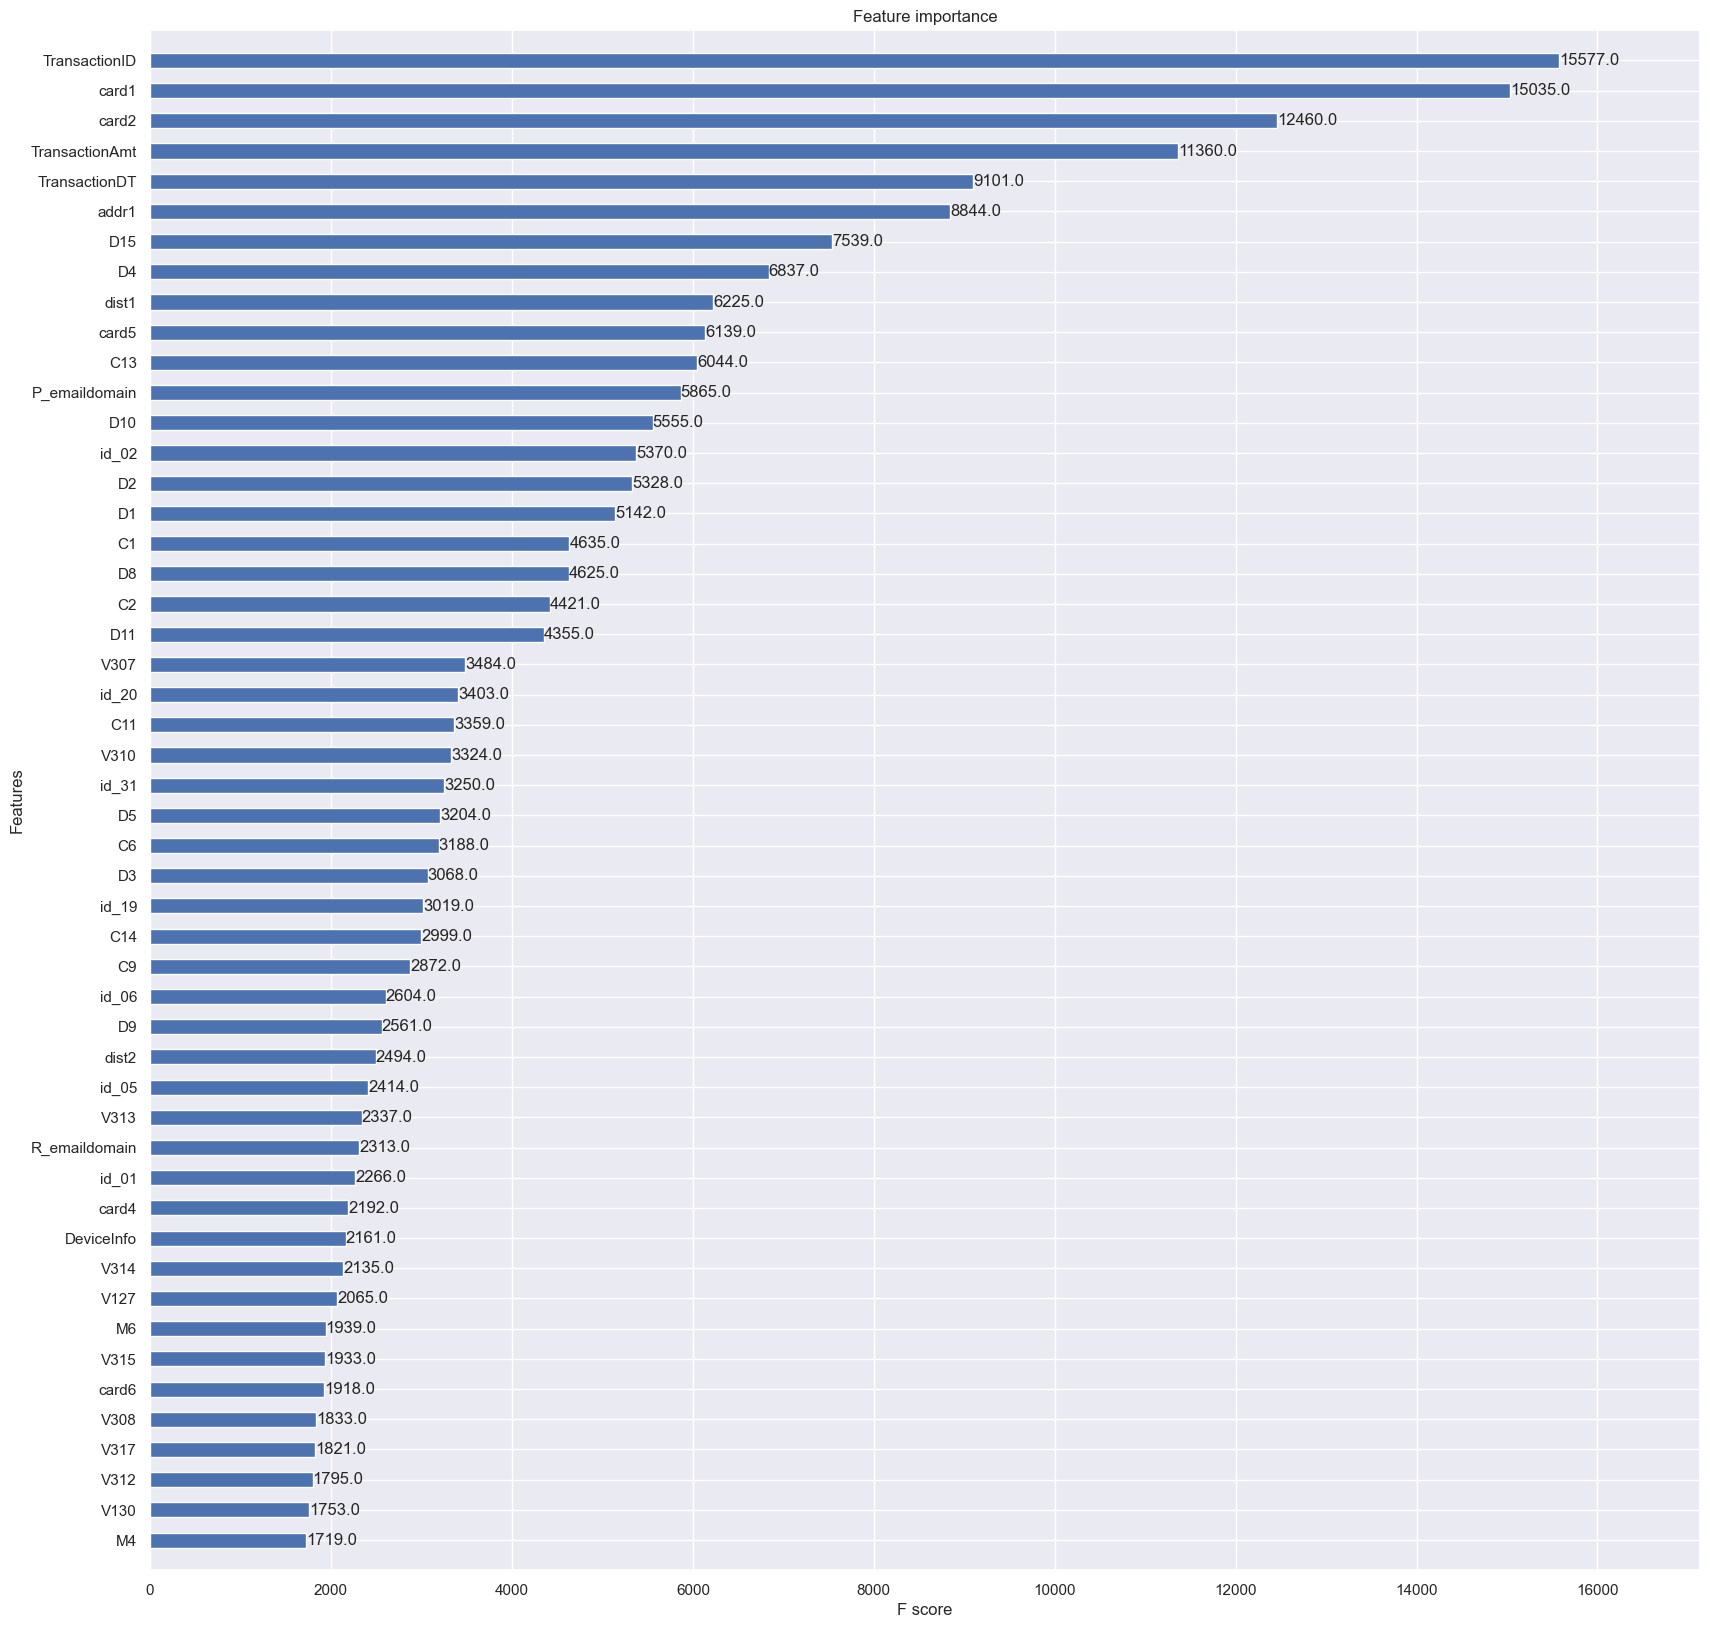

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,20))
plot_importance(model,max_num_features=50,height=0.5,ax=axes)
plt.show()

In [ ]:
"neural network": MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=10, max_iter=1000),

ValueError: Length of values (3) does not match length of index (1)

In [ ]:
"KNN": KNeighborsClassifier(),

In [ ]:
# Feature importances
pd.Series(rfc.feature_importances_, index=X_train.columns).nlargest(15).plot(kind='barh')
plt.show()